## Autora: Shirley Claudette Martínez Cerrato

In [1]:
import sys
!{sys.executable} -m pip install pycm
!{sys.executable} -m pip install imblearn
from hdbcli import dbapi
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns
sns.set(style="ticks")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from pycm import ConfusionMatrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### Productos Disponibles

In [2]:
productos_bancarios = ('1. CUENTA_CHEQUES', 
'2. CUENTA_AHORROS',
'3. DEPOSITOS_A_PLAZO',
'4. BONOS_DE_CAJA',
'5. PRESTAMOS_CONSUMO',
'6. PRESTAMOS_VIVIENDA',
'7. ADELANTO_PAGO_PLUS',
'8. EXTRAFINANCIAMIENTO',
'9. TC_VISA', 
'10. TC_CASHBACK', 
'11. TC_OLIMPIA',
'12. TC_HMC',
'13. TC_LADY_LEE',
'14. TC_PUMA',
'15. TC_ANTORCHA',
'16. TC_CELEBRA')

In [3]:
print(productos_bancarios)

('1. CUENTA_CHEQUES', '2. CUENTA_AHORROS', '3. DEPOSITOS_A_PLAZO', '4. BONOS_DE_CAJA', '5. PRESTAMOS_CONSUMO', '6. PRESTAMOS_VIVIENDA', '7. ADELANTO_PAGO_PLUS', '8. EXTRAFINANCIAMIENTO', '9. TC_VISA', '10. TC_CASHBACK', '11. TC_OLIMPIA', '12. TC_HMC', '13. TC_LADY_LEE', '14. TC_PUMA', '15. TC_ANTORCHA', '16. TC_CELEBRA')


#### Creamos la conexión a la base de datos

In [6]:
#Cambiar las credenciales user y password
try:
    conn = dbapi.connect(
        address="000.000.00.000", 
        port=0, 
        user="user", 
        password="********"
    )
except:
    print('Error de Conexión')

# Predicción de Abandono para Tarejta de Crédito Visa

**Las consultas mostradas a continuación han sido reemplazadas por consultas donde se han cambiado el nombre de las variables y se han anonimizado algunos valores con el fin de protejer la seguridad e integridad del data Warehouse**

In [7]:
cursor = conn.cursor()
sql_command = """SELECT A.CODIGO_DE_CLIENTE, B.CAMPO_GENERO, B.CAMPO_ESTADO_CIVIL, B.CAMPO_NIVEL_EDUCATIVO, B.CAMPO_OCUPACION, 
B.CAMPO_GENERACION, B.CAMPO_REGION, B.CREDITOS_DE_CLIENTE, B.DEBITOS_DE_CLIENTE, B.TRANSACCIONES_PROMEDIO_CLIENTE, A.ESTADO_PRODUCTO
FROM (
SELECT TO_CHAR(A.CODIGO_DE_CLIENTE) AS CODIGO_DE_CLIENTE, A.NUMERO_DE_CUENTA_DEL_PRODUCTO,
(CASE WHEN B.CAMPO_ESTADO_DE_LA_TARJETA IS NULL THEN 'Abandono' 
WHEN B.CAMPO_ESTADO_DE_LA_TARJETA IN ('CODIGOS PARA TARJETAS ACTIVAS')  THEN 'Vigente' ELSE 'Abandono' END) AS ESTADO_PRODUCTO
FROM 
(SELECT * FROM ESQUEMA.TABLA_PRODUCTOS_TARJETAS_DE_CREDITO WHERE PERIODO_DE_ANALISIS BETWEEN TO_DATE('20200301', 'YYYYMMDD') 
AND ADD_MONTHS(TO_DATE('20200301', 'YYYYMMDD'), 12) AND TO_DATE(FECHA_ADQUISICION_PRODUCTO, 'YYYYMMDD') = PERIODO_DE_ANALISIS
AND CODIGO_PRODUCTO_TAREJTA IN ('CODIGOS DEL PRODUCTO')) AS A
LEFT JOIN
(SELECT * FROM ESQUEMA.TABLA_PRODUCTOS_TARJETAS_DE_CREDITO WHERE PERIODO_DE_ANALISIS BETWEEN ADD_MONTHS(TO_DATE('20200301', 'YYYYMMDD'), 6) 
AND ADD_MONTHS(ADD_MONTHS(TO_DATE('20200301', 'YYYYMMDD'), 12), 6)) AS B
ON A.NUMERO_DE_CUENTA_DEL_PRODUCTO = B.NUMERO_DE_CUENTA_DEL_PRODUCTO AND TO_DATE(A.FECHA_ADQUISICION_PRODUCTO, 'YYYYMMDD') = ADD_MONTHS(B.PERIODO_DE_ANALISIS, -6)
) AS A
INNER JOIN
(SELECT A.CODIGO_DE_CLIENTE,
A.CAMPO_GENERO, 
(CASE WHEN A.CAMPO_ESTADO_CIVIL IN ('CASADO/A', 'MARRIED', 'VERHEIRATET') THEN 'CASADO/A'
WHEN A.CAMPO_ESTADO_CIVIL IN ('DIVORCED', 'DIVORCIADO/A', 'GESCHIEDEN') THEN 'DIVORCIADO/A'
WHEN A.CAMPO_ESTADO_CIVIL IN ('GETRENNT LEBEND', 'SEPARATED') THEN 'SEPARADO/A'
WHEN A.CAMPO_ESTADO_CIVIL IN ('LEDIG', 'SINGLE', 'SOLTERO/A') THEN 'SOLTERO/A'
WHEN A.CAMPO_ESTADO_CIVIL IN ('VERWITWET', 'VIUDO', 'WIDOWED') THEN 'VIUDO/A'
WHEN A.CAMPO_ESTADO_CIVIL LIKE 'UNIÓN LIBRE' THEN 'UNIÓN LIBRE'
ELSE '' END) AS CAMPO_ESTADO_CIVIL, 
(CASE WHEN A.CAMPO_NIVEL_EDUCATIVO IN ('DOCTORADO', 'DOKTOR', 'DR') THEN 'DOCTORADO'
ELSE A.CAMPO_NIVEL_EDUCATIVO END) AS CAMPO_NIVEL_EDUCATIVO,
A.CAMPO_OCUPACION,
B.EDAD_SEGMENTACION AS CAMPO_GENERACION,
B.CAMPO_REGION,
ROUND(IFNULL(T.CREDITO_ULTIMO_ANIO, 0), 2) AS CREDITOS_DE_CLIENTE, 
ROUND(IFNULL(T.DEBITO_ULTIMO_ANIO, 0), 2) AS DEBITOS_DE_CLIENTE,
ROUND(IFNULL(T.NUM_TRANSACCIONES_PROMEDIO_CLIENTE, 0), 2) AS TRANSACCIONES_PROMEDIO_CLIENTE
FROM ESQUEMA.TABLA_CRM_PRINCIPAL AS A
INNER JOIN ESQUEMA.TABLA_CRM_SECUNDARIO AS B ON A.CODIGO_DE_CLIENTE = B.CODIGO_DE_CLIENTE
LEFT JOIN (SELECT TO_CHAR(CODIGO_DE_CLIENTE) AS CODIGO_DE_CLIENTE, TO_DOUBLE(SUM(CASE WHEN TIPO_TRANSACCION='CREDITO' THEN MONTO_TRANSACCION ELSE 0  END )/12) CREDITO_ULTIMO_ANIO,
TO_DOUBLE(ABS(SUM(CASE WHEN TIPO_TRANSACCION='DEBITO' THEN MONTO_TRANSACCION ELSE 0  END ))/12) DEBITO_ULTIMO_ANIO,
TO_DOUBLE(SUM(CASE WHEN CODIGO_CATEGORIA_TRANSACCION IN ('CODIGOS PARA DEBITOS') AND TIPO_TRANSACCION='DEBITO' THEN 1 ELSE 0 END)/12) AS NUM_TRANSACCIONES_PROMEDIO_CLIENTE
FROM ESQUEMA.TABLA_TRANSACCIONAL
WHERE (PERIODO_DE_ANALISIS BETWEEN TO_INT(TO_CHAR(ADD_MONTHS(CURRENT_DATE, -12), 'YYYYMMDD')) AND TO_INT(TO_CHAR(ADD_DAYS(CURRENT_DATE, -1), 'YYYYMMDD')))
AND LEFT(CAMPO_NUMERO_CUENTA_CONTABLE,3) IN ('CODIGOS_PARA_CUENTAS_DE_DEPOSITO') AND NUMERO_CUENTA_DETALLE != 0 GROUP BY CODIGO_DE_CLIENTE) AS T ON A.CODIGO_DE_CLIENTE = T.CODIGO_DE_CLIENTE
WHERE A.CAMPO_ESTADO_CLIENTE LIKE 'ACTIVO' AND A.CAMPO_BANCA_DE_CLIENTE LIKE 'SEGMENTO PERSONAS'
AND A.CAMPO_GENERO NOT LIKE 'N/A'
AND A.CAMPO_ESTADO_CIVIL NOT LIKE ''
AND A.CAMPO_NIVEL_EDUCATIVO NOT LIKE ''
AND A.CAMPO_OCUPACION NOT LIKE 'N/A'
AND B.EDAD_SEGMENTACION NOT LIKE 'O'
AND B.CAMPO_REGION NOT LIKE 'SIN DEFINIR') AS B ON A.CODIGO_DE_CLIENTE = B.CODIGO_DE_CLIENTE;"""

In [8]:
cursor.execute(sql_command)
rows = cursor.fetchall()

In [9]:
new_records = pd.DataFrame(rows, columns=['CODIGO_CLIENTE','GENERO', 'ESTADO_CIVIL', 'NUMERO_DEPENDIENTES',
                                          'NIVEL_EDUCATIVO', 'OCUPACION', 'GENERACION', 'REGION', 'CREDITOS',
                                          'DEBITOS', 'TRANSACCIONES_PROMEDIO','ESTADO_PRODUCTO'])

In [10]:
new_records

,CODIGO_CLIENTE,GENERO,ESTADO_CIVIL,NUMERO_DEPENDIENTES,NIVEL_EDUCATIVO,OCUPACION,GENERACION,REGION,CREDITOS,DEBITOS,TRANSACCIONES_PROMEDIO,ESTADO_PRODUCTO
0,1815457,FEMENINO,SOLTERO/A,0,SECUNDARIA,EMPLEADO PRIVADO,Y,NORTE,0.00,10.67,0.00,Abandono
1,2444059,FEMENINO,UNIÓN LIBRE,0,SECUNDARIA,EMPLEADO PRIVADO,Y,CENTRO-SUR,0.14,0.00,0.00,Abandono
2,2460127,MASCULINO,SOLTERO/A,0,SECUNDARIA,EMPLEADO PRIVADO,Z,NORTE,0.00,0.00,0.00,Abandono
3,2533102,FEMENINO,CASADO/A,0,UNIVERSITARIA,EMPLEADO PRIVADO,X,CENTRO-SUR,17430.81,224.16,1.50,Vigente
4,2164208,MASCULINO,SOLTERO/A,0,SECUNDARIA,EMPLEADO PÚBLICO,Y,CENTRO-SUR,23837.52,8805.48,5.33,Vigente
...,...,...,...,...,...,...,...,...,...,...,...,...
1071,1698749,FEMENINO,SOLTERO/A,0,SECUNDARIA,EMPLEADO PRIVADO,Y,NORTE,63584.88,8820.75,3.17,Vigente
1072,1426632,MASCULINO,SOLTERO/A,0,SECUNDARIA,EMPLEADO PRIVADO,Y,CENTRO-SUR,14876.57,9180.27,3.25,Vigente
1073,1560646,MASCULINO,CASADO/A,0,UNIVERSITARIA,COMERCIANTE INDIVIDU,X,CENTRO-SUR,0.00,13.15,0.00,Vigente
1074,1487266,MASCULINO,CASADO/A,0,SECUNDARIA,EMPLEADO PRIVADO,Y,CENTRO-SUR,51011.50,30218.57,19.58,Vigente


### Empezamos a explorar el dataset para conocer los aspectos generales del conjunto de datos

In [11]:
print(new_records.shape)#Para saber el número de registros (instancias) y columnas (atributos)

(1076, 12)


In [12]:
print(new_records.groupby('ESTADO_PRODUCTO').size())#Para visualizar los valores de la clase de salida y los valores que la conforman

ESTADO_PRODUCTO
Abandono    189
Vigente     887
dtype: int64


In [13]:
new_records.info()#para visualizar inofrmación de los atributos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CODIGO_CLIENTE          1076 non-null   object 
 1   GENERO                  1076 non-null   object 
 2   ESTADO_CIVIL            1076 non-null   object 
 3   NUMERO_DEPENDIENTES     1076 non-null   int64  
 4   NIVEL_EDUCATIVO         1076 non-null   object 
 5   OCUPACION               1076 non-null   object 
 6   GENERACION              1076 non-null   object 
 7   REGION                  1076 non-null   object 
 8   CREDITOS                1076 non-null   float64
 9   DEBITOS                 1076 non-null   float64
 10  TRANSACCIONES_PROMEDIO  1076 non-null   float64
 11  ESTADO_PRODUCTO         1076 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 101.0+ KB


In [14]:
new_records.describe()

,NUMERO_DEPENDIENTES,CREDITOS,DEBITOS,TRANSACCIONES_PROMEDIO
count,1076.000000,1.076000e+03,1.076000e+03,1076.000000
mean,0.183086,4.550679e+04,2.066354e+04,6.602974
std,0.582642,1.894182e+05,7.442525e+04,13.520965
min,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000
50%,0.000000,9.136780e+03,3.573835e+03,1.670000
75%,0.000000,3.488085e+04,1.695603e+04,8.500000
max,5.000000,4.631766e+06,1.479764e+06,233.170000


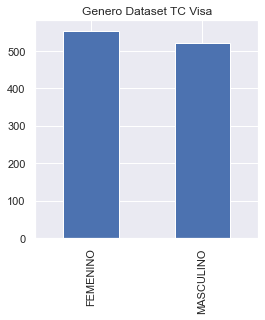

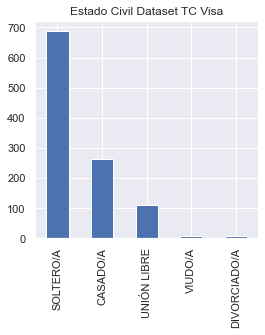

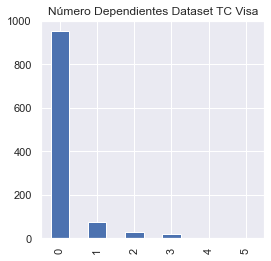

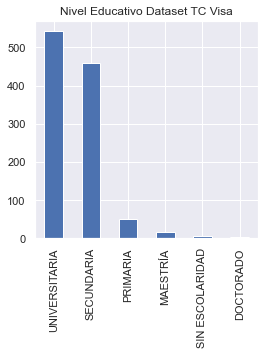

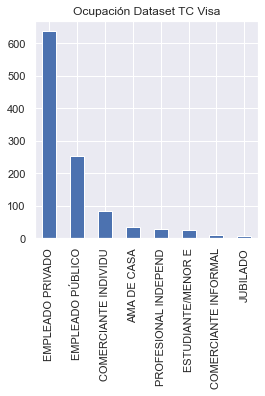

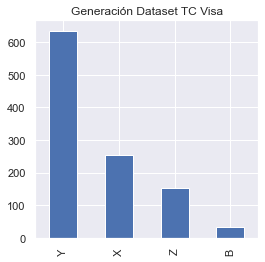

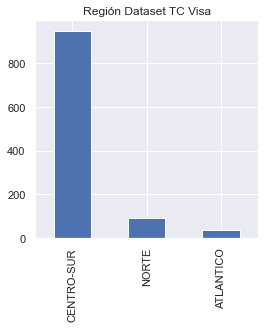

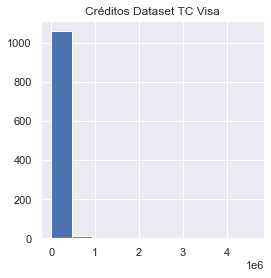

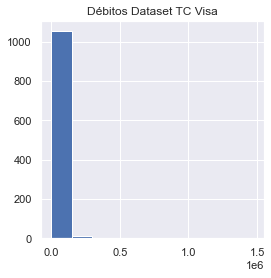

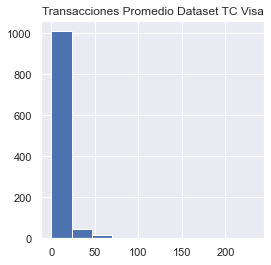

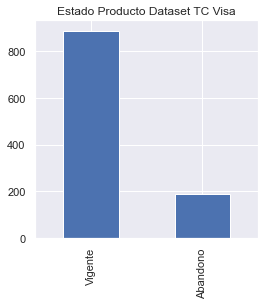

In [15]:
sns.set(style="darkgrid")
pyplot.figure(figsize=(4,4))
pyplot.subplot(1,1,1)
new_records['GENERO'].value_counts().plot(kind='bar', title='Genero Dataset TC Visa')
pyplot.show()

pyplot.figure(figsize=(4,4))
pyplot.subplot(1,1,1)
new_records['ESTADO_CIVIL'].value_counts().plot(kind='bar', title='Estado Civil Dataset TC Visa')
pyplot.show()

pyplot.figure(figsize=(4,4))
pyplot.subplot(1,1,1)
new_records['NUMERO_DEPENDIENTES'].value_counts().plot(kind='bar', title='Número Dependientes Dataset TC Visa')
pyplot.show()

pyplot.figure(figsize=(4,4))
pyplot.subplot(1,1,1)
new_records['NIVEL_EDUCATIVO'].value_counts().plot(kind='bar', title='Nivel Educativo Dataset TC Visa')
pyplot.show()

pyplot.figure(figsize=(4,4))
pyplot.subplot(1,1,1)
new_records['OCUPACION'].value_counts().plot(kind='bar', title='Ocupación Dataset TC Visa')
pyplot.show()

pyplot.figure(figsize=(4,4))
pyplot.subplot(1,1,1)
new_records['GENERACION'].value_counts().plot(kind='bar', title='Generación Dataset TC Visa')
pyplot.show()

pyplot.figure(figsize=(4,4))
pyplot.subplot(1,1,1)
new_records['REGION'].value_counts().plot(kind='bar', title='Región Dataset TC Visa')
pyplot.show()

pyplot.figure(figsize=(4,4))
pyplot.subplot(1,1,1).set_title('Créditos Dataset TC Visa')
pyplot.hist(new_records['CREDITOS'])
pyplot.show()

pyplot.figure(figsize=(4,4))
pyplot.subplot(1,1,1).set_title('Débitos Dataset TC Visa')
pyplot.hist(new_records['DEBITOS'])
pyplot.show()

pyplot.figure(figsize=(4,4))
pyplot.subplot(1,1,1).set_title('Transacciones Promedio Dataset TC Visa')
pyplot.hist(new_records['TRANSACCIONES_PROMEDIO'])
#new_records.hist()
pyplot.show()

pyplot.figure(figsize=(4,4))
pyplot.subplot(1,1,1)
new_records['ESTADO_PRODUCTO'].value_counts().plot(kind='bar', title='Estado Producto Dataset TC Visa')
pyplot.show()

### Creación del Conjunto de Entrenamiento y validación

Primero normalizamos la variable 'NUMERO_DEPENDIENTES'

In [16]:
sc = StandardScaler()

In [17]:
#num_dependientes_norm = (new_records[['NUMERO_DEPENDIENTES']] - 
#                         new_records[['NUMERO_DEPENDIENTES']].min())/(new_records[['NUMERO_DEPENDIENTES']].max()-new_records[['NUMERO_DEPENDIENTES']].min())

In [18]:
num_dependientes_norm = pd.DataFrame(sc.fit_transform(new_records[['NUMERO_DEPENDIENTES']]), 
                                     columns = ['NUMERO_DEPENDIENTES'])
creditos_norm = pd.DataFrame(sc.fit_transform(new_records[['CREDITOS']]),
                             columns = ['CREDITOS'])
debitos_norm = pd.DataFrame(sc.fit_transform(new_records[['DEBITOS']]),
                            columns = ['DEBITOS'])
transacciones_prom_norm = pd.DataFrame(sc.fit_transform(new_records[['TRANSACCIONES_PROMEDIO']]),
                                       columns = ['TRANSACCIONES_PROMEDIO'])

Se crean los dummies para cada variable

In [19]:
genero_dm = pd.get_dummies(new_records.GENERO, prefix='GENERO')
estado_civil_dm = pd.get_dummies(new_records.ESTADO_CIVIL, prefix='EC')
nivel_educativo_dm = pd.get_dummies(new_records.NIVEL_EDUCATIVO, prefix='NIVEL_ED')
ocupacion_dm = pd.get_dummies(new_records.OCUPACION, prefix='OCUPACION')
generacion_dm = pd.get_dummies(new_records.GENERACION, prefix='GENERACION')
region_dm = pd.get_dummies(new_records.REGION, prefix='REGION')

In [20]:
#numero_dependientes_dm = pd.get_dummies(new_records.NUMERO_DEPENDIENTES, prefix='NUM_DEPEN')

In [21]:
#segmento_ingreso_dm = pd.get_dummies(new_records.SEGMENTO_INGRESO, prefix='INGRESO')

Se crea el nuevo dataset con los dummies y la variable normalizada

In [22]:
dataset_transformado = pd.concat([genero_dm, estado_civil_dm, num_dependientes_norm,
                                                 nivel_educativo_dm, ocupacion_dm, generacion_dm,
                                                 region_dm, creditos_norm, debitos_norm,
                                                 transacciones_prom_norm, new_records[['ESTADO_PRODUCTO']]], axis=1)

In [23]:
dataset_transformado.shape

(1076, 33)

In [24]:
lista_datos = dataset_transformado.values
X = lista_datos[:,0:32]
y = lista_datos[:,32]

In [25]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, shuffle=True,test_size=0.20, random_state=10)

Aplicamos la técnica de SMOTE para conseguir el conjunto de datos de entrenamiento

In [26]:
smote = SMOTE()
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

In [27]:
print("Before SMOTE :" , Counter(Y_train))
print("After SMOTE :" , Counter(Y_train_smote))

Before SMOTE : Counter({'Vigente': 709, 'Abandono': 151})
After SMOTE : Counter({'Vigente': 709, 'Abandono': 709})


In [28]:
nombre_clases = ['Abandono', 'Vigente']

## Definimos el diccionario de Variables de análisis

In [29]:
#Se crea un diccionario para cada dataset, el cual contendra un diccionario por cada algoritmo a probar
analisis = {'CART': {}, 'RF': {}, 'KN': {}, 'LReg': {}}

### Entrenamos el modelo CART

In [30]:
analisis['CART']['model'] = DecisionTreeClassifier()
analisis['CART']['model'].fit(X_train_smote, Y_train_smote)
analisis['CART']['model'].classes_

array(['Abandono', 'Vigente'], dtype=object)

Luego lo validamos con el conjunto de datos de validación

In [31]:
analisis['CART']['pred_score'] = analisis['CART']['model'].predict(X_validation)
print(accuracy_score(Y_validation, analisis['CART']['pred_score']))

0.6666666666666666


Matriz de Confusión CART Dataset TC Visa Sin Normalizar
[[ 10  28]
 [ 44 134]]
Matriz de Confusión CART Dataset TC Visa Normalizada
[[0.26315789 0.73684211]
 [0.24719101 0.75280899]]


C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


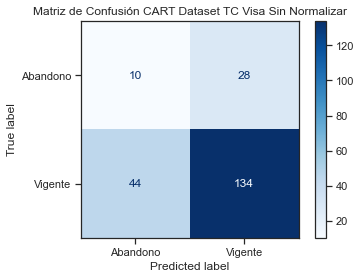

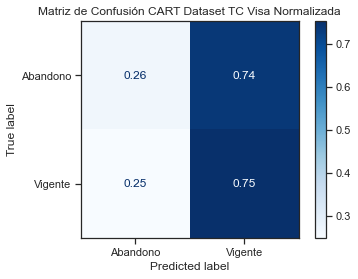

In [32]:
# Plot non-normalized confusion matrix - Tomado de la documentación oficial de scikitlearn
sns.set(style="ticks")
titulos_cm = [("Matriz de Confusión CART Dataset TC Visa Sin Normalizar", None),
                  ("Matriz de Confusión CART Dataset TC Visa Normalizada", 'true')]
for titulo, normalizacion in titulos_cm:
    cart_visualizacion_cm = plot_confusion_matrix(analisis['CART']['model'], X_validation, Y_validation,
                                 display_labels=nombre_clases,
                                 cmap=pyplot.cm.Blues,
                                 normalize=normalizacion)
    cart_visualizacion_cm.ax_.set_title(titulo)

    print(titulo)
    print(cart_visualizacion_cm.confusion_matrix)

pyplot.show()

In [33]:
analisis['CART']['metricas'] = classification_report(Y_validation, analisis['CART']['pred_score'])
print(analisis['CART']['metricas'])

              precision    recall  f1-score   support

    Abandono       0.19      0.26      0.22        38
     Vigente       0.83      0.75      0.79       178

    accuracy                           0.67       216
   macro avg       0.51      0.51      0.50       216
weighted avg       0.71      0.67      0.69       216



También utilizamos la librería pycm para obtener estadísticas más precisas de nuestro modelo predictivo como ser TPR y FPR

In [34]:
analisis['CART']['estadisticas'] = ConfusionMatrix(actual_vector=Y_validation,predict_vector=analisis['CART']['pred_score'])
print(analisis['CART']['estadisticas'])

Predict        Abandono       Vigente        
Actual
Abandono       10             28             

Vigente        44             134            





Overall Statistics : 

95% CI                                                            (0.6038,0.72953)
ACC Macro                                                         0.66667
ARI                                                               0.00455
AUNP                                                              0.50798
AUNU                                                              0.50798
Bangdiwala B                                                      0.58456
Bennett S                                                         0.33333
CBA                                                               0.469
CSI                                                               0.01416
Chi-Squared                                                       0.04258
Chi-Squared DF                                                    1
Conditional

In [35]:
analisis['CART']['predY'] = analisis['CART']['model'].predict_proba(X_validation)
analisis['CART']['fpr'], analisis['CART']['tpr'], analisis['CART']['thresh'] = roc_curve(Y_validation, 
                                                               analisis['CART']['predY'][:,0], pos_label = 'Abandono')
#print(analisis['CART']['fpr'])
#print(analisis['CART']['tpr'])
#print(analisis['CART']['thresh'])
analisis['CART']['auc'] = auc(analisis['CART']['fpr'], analisis['CART']['tpr'])
print("AUC:", analisis['CART']['auc'])

AUC: 0.5239503252513306


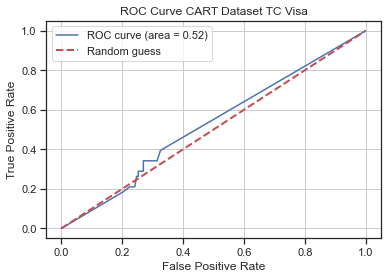

In [36]:
pyplot.plot(analisis['CART']['fpr'], analisis['CART']['tpr'], label='ROC curve (area = %.2f)' %analisis['CART']['auc'])
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.title('ROC Curve CART Dataset TC Visa')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.grid()
pyplot.legend()
pyplot.show()

### Entrenamos el modelo Random Forest

In [37]:
analisis['RF']['model'] = RandomForestClassifier()
analisis['RF']['model'].fit(X_train_smote, Y_train_smote)
analisis['RF']['model'].classes_

array(['Abandono', 'Vigente'], dtype=object)

In [38]:
analisis['RF']['pred_score'] = analisis['RF']['model'].predict(X_validation)
print(accuracy_score(Y_validation, analisis['RF']['pred_score']))

0.7268518518518519


Matriz de Confusión RF Dataset TC Visa Sin Normalizar
[[ 12  26]
 [ 33 145]]
Matriz de Confusión RF Dataset TC Visa Normalizada
[[0.31578947 0.68421053]
 [0.18539326 0.81460674]]


C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


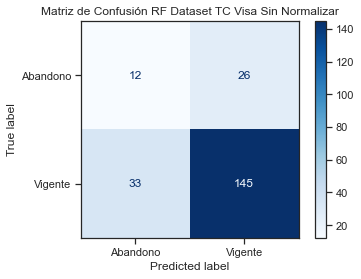

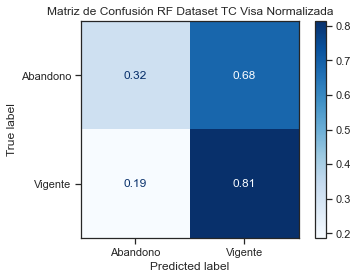

In [39]:
# Plot non-normalized confusion matrix - Tomado de la documentación oficial de scikitlearn
sns.set(style="ticks")
titulos_cm = [("Matriz de Confusión RF Dataset TC Visa Sin Normalizar", None),
                  ("Matriz de Confusión RF Dataset TC Visa Normalizada", 'true')]
for titulo, normalizacion in titulos_cm:
    rf_visualizacion_cm = plot_confusion_matrix(analisis['RF']['model'], X_validation, Y_validation,
                                 display_labels=nombre_clases,
                                 cmap=pyplot.cm.Blues,
                                 normalize=normalizacion)
    rf_visualizacion_cm.ax_.set_title(titulo)

    print(titulo)
    print(rf_visualizacion_cm.confusion_matrix)

pyplot.show()

In [40]:
analisis['RF']['metricas'] = classification_report(Y_validation, analisis['RF']['pred_score'])
print(analisis['RF']['metricas'])

              precision    recall  f1-score   support

    Abandono       0.27      0.32      0.29        38
     Vigente       0.85      0.81      0.83       178

    accuracy                           0.73       216
   macro avg       0.56      0.57      0.56       216
weighted avg       0.75      0.73      0.74       216



In [41]:
analisis['RF']['estadisticas'] = ConfusionMatrix(actual_vector=Y_validation,predict_vector=analisis['RF']['pred_score'])
print(analisis['RF']['estadisticas'])

Predict        Abandono       Vigente        
Actual
Abandono       12             26             

Vigente        33             145            





Overall Statistics : 

95% CI                                                            (0.66743,0.78627)
ACC Macro                                                         0.72685
ARI                                                               0.07146
AUNP                                                              0.5652
AUNU                                                              0.5652
Bangdiwala B                                                      0.65849
Bennett S                                                         0.4537
CBA                                                               0.54064
CSI                                                               0.12251
Chi-Squared                                                       3.22834
Chi-Squared DF                                                    1
Conditional

In [42]:
analisis['RF']['predY'] = analisis['RF']['model'].predict_proba(X_validation)
analisis['RF']['fpr'], analisis['RF']['tpr'], analisis['RF']['thresh'] = roc_curve(Y_validation, 
                                                               analisis['RF']['predY'][:,0], pos_label = 'Abandono')
#print(analisis['CART']['fpr'])
#print(analisis['CART']['tpr'])
#print(analisis['CART']['thresh'])
analisis['RF']['auc'] = auc(analisis['RF']['fpr'], analisis['RF']['tpr'])
print("AUC:", analisis['RF']['auc'])

AUC: 0.5952099349497338


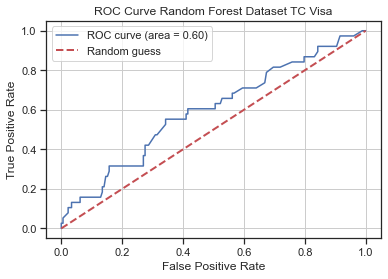

In [43]:
pyplot.plot(analisis['RF']['fpr'], analisis['RF']['tpr'], label='ROC curve (area = %.2f)' %analisis['RF']['auc'])
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.title('ROC Curve Random Forest Dataset TC Visa')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.grid()
pyplot.legend()
pyplot.show()

### Entrenamos el modelo KNeighbors

Text(0, 0.5, 'Recall para Clase Abandono')

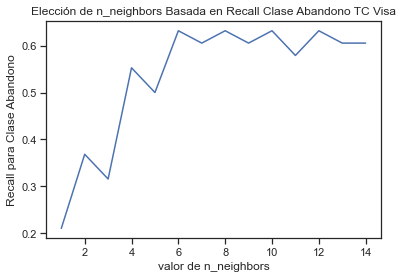

In [44]:
range_k = range(1,15)
kn_scores = []
kn_scores_list = []
for k in range_k:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train_smote, Y_train_smote)
    kn_y_pred = classifier.predict(X_validation)
    kn_scores.append(accuracy_score(Y_validation,kn_y_pred))
    #kn_scores_list.append(accuracy_score(Y_validation, kn_y_pred))
    kn_scores_list.append(recall_score(Y_validation, kn_y_pred, pos_label = 'Abandono'))

pyplot.plot(range_k,kn_scores_list)
pyplot.title('Elección de n_neighbors Basada en Recall Clase Abandono TC Visa')
pyplot.xlabel("valor de n_neighbors")
pyplot.ylabel("Recall para Clase Abandono")

In [45]:
analisis['KN']['model'] = KNeighborsClassifier(n_neighbors=6)
analisis['KN']['model'].fit(X_train_smote, Y_train_smote)
analisis['KN']['model'].classes_

array(['Abandono', 'Vigente'], dtype=object)

In [46]:
analisis['KN']['pred_score'] = analisis['KN']['model'].predict(X_validation)
print(accuracy_score(Y_validation, analisis['KN']['pred_score']))

0.6018518518518519


C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Matriz de Confusión KNeighbors Dataset TC Visa Sin Normalizar
[[ 24  14]
 [ 72 106]]
Matriz de Confusión KNeighbors Dataset TC Visa Normalizada
[[0.63157895 0.36842105]
 [0.40449438 0.59550562]]


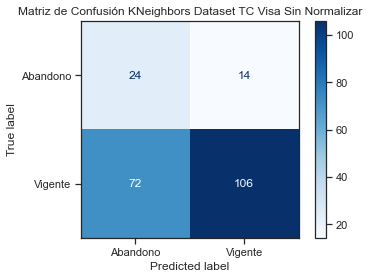

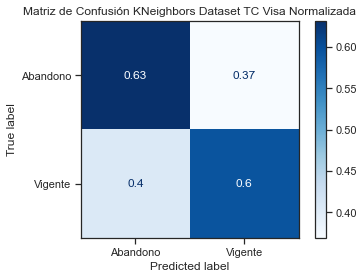

In [47]:
# Plot non-normalized confusion matrix - Tomado de la documentación oficial de scikitlearn
sns.set(style="ticks")
titulos_cm = [("Matriz de Confusión KNeighbors Dataset TC Visa Sin Normalizar", None),
                  ("Matriz de Confusión KNeighbors Dataset TC Visa Normalizada", 'true')]
for titulo, normalizacion in titulos_cm:
    kn_visualizacion_cm = plot_confusion_matrix(analisis['KN']['model'], X_validation, Y_validation,
                                 display_labels=nombre_clases,
                                 cmap=pyplot.cm.Blues,
                                 normalize=normalizacion)
    kn_visualizacion_cm.ax_.set_title(titulo)

    print(titulo)
    print(kn_visualizacion_cm.confusion_matrix)

pyplot.show()

In [48]:
analisis['KN']['metricas'] = classification_report(Y_validation, analisis['KN']['pred_score'])
print(analisis['KN']['metricas'])

              precision    recall  f1-score   support

    Abandono       0.25      0.63      0.36        38
     Vigente       0.88      0.60      0.71       178

    accuracy                           0.60       216
   macro avg       0.57      0.61      0.53       216
weighted avg       0.77      0.60      0.65       216



In [49]:
analisis['KN']['estadisticas'] = ConfusionMatrix(actual_vector=Y_validation,predict_vector=analisis['KN']['pred_score'])
print(analisis['KN']['estadisticas'])

Predict        Abandono       Vigente        
Actual
Abandono       24             14             

Vigente        72             106            





Overall Statistics : 

95% CI                                                            (0.53657,0.66713)
ACC Macro                                                         0.60185
ARI                                                               0.03391
AUNP                                                              0.61354
AUNU                                                              0.61354
Bangdiwala B                                                      0.47233
Bennett S                                                         0.2037
CBA                                                               0.42275
CSI                                                               0.18021
Chi-Squared                                                       6.54004
Chi-Squared DF                                                    1
Condition

In [50]:
analisis['KN']['predY'] = analisis['KN']['model'].predict_proba(X_validation)
analisis['KN']['fpr'], analisis['KN']['tpr'], analisis['KN']['thresh'] = roc_curve(Y_validation, 
                                                               analisis['KN']['predY'][:,0], pos_label = 'Abandono')
#print(analisis['KN']['fpr'])
#print(analisis['KN']['tpr'])
#print(analisis['KN']['thresh'])
analisis['KN']['auc'] = auc(analisis['KN']['fpr'], analisis['KN']['tpr'])
print("AUC:", analisis['KN']['auc'])

AUC: 0.6221170904790065


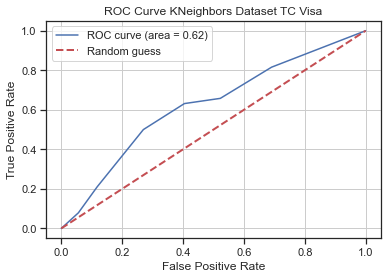

In [51]:
pyplot.plot(analisis['KN']['fpr'], analisis['KN']['tpr'], label='ROC curve (area = %.2f)' %analisis['KN']['auc'])
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.title('ROC Curve KNeighbors Dataset TC Visa')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.grid()
pyplot.legend()
pyplot.show()

### Entrenamos el modelo Logistic Regression

C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Text(0, 0.5, 'Recall para Clase Abandono')

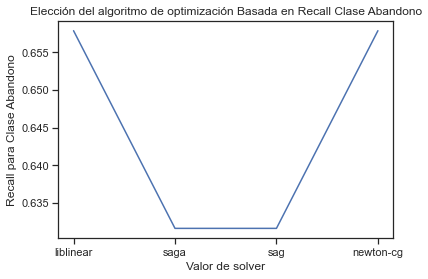

In [52]:
solver = ['liblinear', 'saga', 'sag', 'newton-cg']
lr_scores = {}
lr_scores_list = []
for k in solver:
   classifier = LogisticRegression(random_state=0, solver=k)
   classifier.fit(X_train_smote, Y_train_smote)
   lr_y_pred = classifier.predict(X_validation)
   lr_scores[k] = accuracy_score(Y_validation,lr_y_pred)
   lr_scores_list.append(recall_score(Y_validation, lr_y_pred, pos_label = 'Abandono'))

pyplot.plot(solver,lr_scores_list)
pyplot.title('Elección del algoritmo de optimización Basada en Recall Clase Abandono')
pyplot.xlabel("Valor de solver")
pyplot.ylabel("Recall para Clase Abandono")

In [53]:
analisis['LReg']['model'] = LogisticRegression(random_state=0, solver="liblinear")
analisis['LReg']['model'].fit(X_train_smote, Y_train_smote)
analisis['LReg']['model'].classes_

array(['Abandono', 'Vigente'], dtype=object)

In [54]:
analisis['LReg']['pred_score'] = analisis['LReg']['model'].predict(X_validation)
print(accuracy_score(Y_validation, analisis['LReg']['pred_score']))

0.6111111111111112


Matriz de Confusión LReg Dataset TC Visa Sin Normalizar
[[ 25  13]
 [ 71 107]]
Matriz de Confusión LReg Dataset TC Visa Normalizada
[[0.65789474 0.34210526]
 [0.3988764  0.6011236 ]]


C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


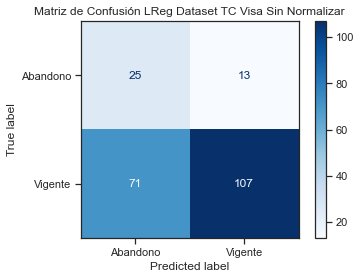

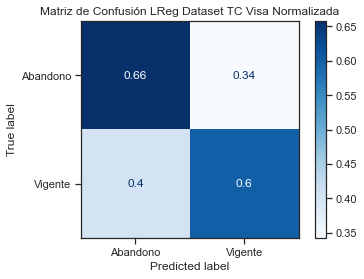

In [55]:
# Plot non-normalized confusion matrix - Tomado de la documentación oficial de scikitlearn
sns.set(style="ticks")
titulos_cm = [("Matriz de Confusión LReg Dataset TC Visa Sin Normalizar", None),
                  ("Matriz de Confusión LReg Dataset TC Visa Normalizada", 'true')]
for titulo, normalizacion in titulos_cm:
    lr_visualizacion_cm = plot_confusion_matrix(analisis['LReg']['model'], X_validation, Y_validation,
                                 display_labels=nombre_clases,
                                 cmap=pyplot.cm.Blues,
                                 normalize=normalizacion)
    lr_visualizacion_cm.ax_.set_title(titulo)

    print(titulo)
    print(lr_visualizacion_cm.confusion_matrix)

pyplot.show()

In [56]:
analisis['LReg']['metricas'] = classification_report(Y_validation, analisis['LReg']['pred_score'])
print(analisis['LReg']['metricas'])

              precision    recall  f1-score   support

    Abandono       0.26      0.66      0.37        38
     Vigente       0.89      0.60      0.72       178

    accuracy                           0.61       216
   macro avg       0.58      0.63      0.55       216
weighted avg       0.78      0.61      0.66       216



In [57]:
analisis['LReg']['estadisticas'] = ConfusionMatrix(actual_vector=Y_validation,predict_vector=analisis['LReg']['pred_score'])
print(analisis['LReg']['estadisticas'])

Predict        Abandono       Vigente        
Actual
Abandono       25             13             

Vigente        71             107            





Overall Statistics : 

95% CI                                                            (0.5461,0.67612)
ACC Macro                                                         0.61111
ARI                                                               0.04186
AUNP                                                              0.62951
AUNU                                                              0.62951
Bangdiwala B                                                      0.48281
Bennett S                                                         0.22222
CBA                                                               0.43077
CSI                                                               0.20555
Chi-Squared                                                       8.50875
Chi-Squared DF                                                    1
Condition

In [58]:
analisis['LReg']['predY'] = analisis['LReg']['model'].predict_proba(X_validation)
analisis['LReg']['fpr'], analisis['LReg']['tpr'], analisis['LReg']['thresh'] = roc_curve(Y_validation, 
                                                               analisis['LReg']['predY'][:,0], pos_label = 'Abandono')
#print(analisis['LReg']['fpr'])
#print(analisis['LReg']['tpr'])
#print(analisis['LReg']['thresh'])
analisis['LReg']['auc'] = auc(analisis['LReg']['fpr'], analisis['LReg']['tpr'])
print("AUC:", analisis['LReg']['auc'])

AUC: 0.6476936723832051


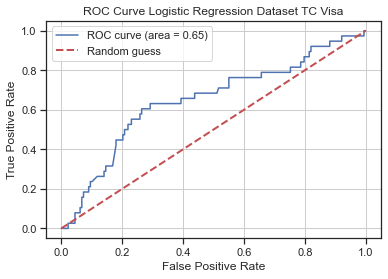

In [59]:
pyplot.plot(analisis['LReg']['fpr'], analisis['LReg']['tpr'], label='ROC curve (area = %.2f)' %analisis['LReg']['auc'])
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.title('ROC Curve Logistic Regression Dataset TC Visa')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.grid()
pyplot.legend()
pyplot.show()